<a href="https://colab.research.google.com/github/Rishit-dagli/Transformer-in-Transformer/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Transformer iN Transformer

[![GitHub stars](https://img.shields.io/github/stars/Rishit-dagli/Transformer-in-Transformer?style=social)](https://github.com/Rishit-dagli/Transformer-in-Transformer/stargazers)
[![GitHub followers](https://img.shields.io/github/followers/Rishit-dagli?label=Follow&style=social)](https://github.com/Rishit-dagli)

This notebook supplements my implementation of the [Transformer iN Transformer](https://github.com/Rishit-dagli/Transformer-in-Transformer) architecture the [Transformer in Transformer](https://arxiv.org/abs/2103.00112) paper by Han et al. for image classification. Transformer in Transformer uses pixel level attention paired with patch level attention.

This examples follows this workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Write a custom training loop to train the model

In this example I use the [TensorFlow Flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset containing more than 3500 images of  flowers, this could easily be done for other datasets as well. The way we load the dataset is heavily inspired by [Image classification](https://www.tensorflow.org/tutorials/images/classification) tutorial on TensorFlow's website. **My goal while creating this notebook to foster readability and reproducibility is to try and keep the notebooks very similar to the Image Classification tutorial on TensorFlow website.**

## Setup

In [1]:
!pip install tnt-tensorflow

In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tnt import TNT

tf.get_logger().setLevel("ERROR")

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


Here are some roses:

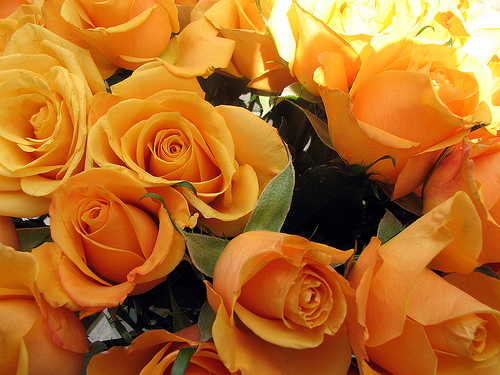

In [5]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[0]))

And some tulips:

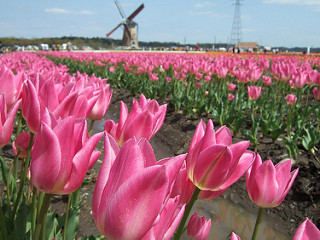

In [6]:
tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[0]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 256
img_width = 256

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

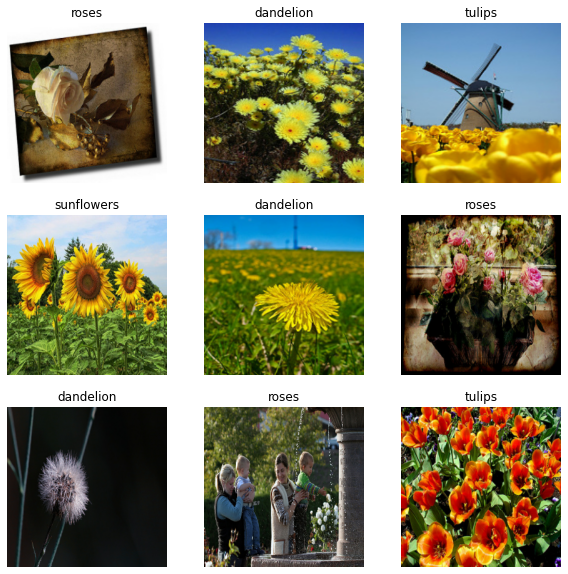

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

We will train a model using these datasets. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 256, 256, 3)`. This is a batch of 32 images of shape `256x256x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

> Note: My implementation though is created to work in the `channels_first format` (you can easily change this) whereas our dataset is in well `channels_last` and we will take care of this while building the model.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [14]:
normalization_layer = layers.Rescaling(1.0 / 255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

We will now create a [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model, the majority of the work here is done by the `TNT` class I provide through my implementation. We also need to handle the channels format like we talked about which is handled by the `einsum` operation.

> Note: Since the goal of this notebook to show a minimal training example we set the depth to be 2 and lower number of dimensions for path and pixel tokens. The accuracy can be increased considerably otherwise.

In [16]:
num_classes = len(class_names)

tnt = TNT(
    image_size=256,  # size of image
    patch_dim=256,  # dimension of patch token
    pixel_dim=6,  # dimension of pixel token
    patch_size=16,  # patch size
    pixel_size=4,  # pixel size
    depth=2,  # depth
    num_classes=num_classes,  # output number of classes
    attn_dropout=0.1,  # attention dropout
    ff_dropout=0.1,  # feedforward dropout
)
model = tf.keras.Sequential(
    [tf.keras.layers.Lambda(lambda x: tf.einsum("...ijk->...kij", x)), tnt]
)

## Train the model

We will now start by writing a custom training loop. Feel free to add the `@tf.function` decorator to speed this up.

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
epochs = 5

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 50 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))


Start of epoch 0
Training loss (for one batch) at step 0: 2.5833
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.6346
Seen so far: 1632 samples

Start of epoch 1
Training loss (for one batch) at step 0: 1.6268
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.6024
Seen so far: 1632 samples

Start of epoch 2
Training loss (for one batch) at step 0: 1.6005
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.6215
Seen so far: 1632 samples

Start of epoch 3
Training loss (for one batch) at step 0: 1.6110
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.6725
Seen so far: 1632 samples

Start of epoch 4
Training loss (for one batch) at step 0: 1.6082
Seen so far: 32 samples
Training loss (for one batch) at step 50: 1.7704
Seen so far: 1632 samples
